# Lab 4: Simple Linear Regression


## Version history

| Date | Author | Description |
|:----:|:------:|:------------|
2021-02-03 | Josiah Wang | First version |
2021-11-13 | Josiah Wang | Optimisation with derivatives: $x$ should be $x^{(i)}$ |
2022-11-02 | Josiah Wang | Updated to `ax = fig.add_subplot(projection='3d')`. The original `fig.gca(projection='3d')` is deprecated.

## Introduction

The aim of this lab exercise is for you to gain some experience implementing and training a simple linear regression model from scratch. This will help you improve your understanding of linear regression and machine learning optimisation.

By the end of this lab exercise, you will have
- implemented a simple linear regression model
- defined and implemented a loss function
- optimised the parameters of your model using gradient descent

There will be a bit less coding required on your side in this exercise compared to previous exercises. The aim is for you to try to really understand linear regression at implementation level to complement the lectures, which will help you in future weeks as you move on to Neural Networks in your coursework assignments.

## Simple Linear Regression

In this tutorial, we will focus on the **regression task**. For simplicity, we will implement a *simple linear regression* model with one input variable and one output variable. More specifically, our task is to predict the value of $y$ given the input $x$.

Let us develop our simple linear regressor with a simple toy example to make sure that our model works correctly. You can later apply it to a bigger dataset if desired.

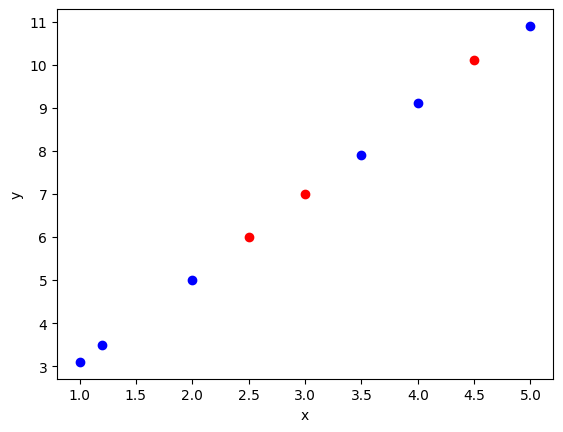

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# toy dataset
x_train = np.array([1.0, 1.2, 2.0, 3.5, 4.0, 5.0])
y_train = np.array([3.1, 3.5, 5.0, 7.9, 9.1, 10.9])
x_test = np.array([2.5, 3.0, 4.5])
y_test = np.array([6.0, 7.0, 10.1])

# plot toy data
plt.scatter(x_train, y_train, c="blue")
plt.scatter(x_test, y_test, c="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Model

As you should be able to see from the plot, the toy dataset can almost be perfectly modelled with a straight line. The model should also be able to pretty accurately predict the value of $y$ of the test set.

Assuming you still remember your high school Maths, a straight line is represented as $y = wx + b$, where $w$ is the slope and $b$ the intercept/bias. Our objective is to find the line that best fits our training data. More specifically, we want our regressor to automatically learn the parameters $w$ and $b$ such that we can accurately predict the real-valued label ${\hat y}$ given an example $x$. The objective is to get ${\hat y}$ to be as close as possible to the values of $y$ of the training data (and presumably the true $y$).

Let us now build our simple linear regression model. Complete the `forward()` method of the `SimpleLinearRegression` class below to return the value of the output $y$ given an input `x` and the current weight `w` and bias `b` of the model.

In [3]:
from numpy.random import default_rng

class SimpleLinearRegression:
    def __init__(self, random_generator=default_rng()):
        # initialise the slope with a random value drawn from a standard normal
        # distribution (mean=0, stddev=1)
        self.w = random_generator.standard_normal()

        # initialise bias to 0
        self.b = 0

    def forward(self, x):
        """ Perform forward pass given an input x

        Args:
            x (float): input instance

        Returns:
            float: the output of the model given the current weights
        """

        # TODO: Complete this
        return self.w * x + self.b

    def loss(self, x, y):
        """ Placeholder for later"""
        pass

    def gradient(self, x, y):
        """ Placeholder for later"""
        pass


## Quick test: This should return 8
model = SimpleLinearRegression()
model.w = 3
model.b = 2
x = 2
y_hat = model.forward(x)
print(y_hat) # should print 8

8


### Loss function

From the plot and the numbers, you may have manually worked out that the 'best' line would be $\hat{y} \approx 2x+1$, that is, the optimal parameter values are $w \approx 2$ and $b \approx 1$.

What constitutes the 'best' line? We will first have to define what 'best' actually means. Intuitively, the 'best' line would be the one that goes through all training points as closely as possible.

To enable our model to automatically learn what the parameter values of the 'best' line are from training examples, we will have to formally define that we mean by 'best'. We define this via a *loss function* (or cost function). For this tutorial, we will use the loss function as in the lectures - the **sum of squared differences** between the predicted label vs. the ground truth label across the training instances.

$$L = \frac{1}{2} \sum_{i=1}^{N} \left(\hat{y}^{(i)} - y^{(i)}\right)^2 = \frac{1}{2} \sum_{i=1}^{N} \left(wx^{(i)} + b - y^{(i)}\right)^2$$

Our objective is to select the parameters $\theta = \{ w, b \}$ that **minimise** the loss (or error).

$$\theta = argmin_{\theta} \, L$$

To make things easy, let us implement the loss function for a **single** instance $x$:

$$L^{(i)} = \left(\hat{y}^{(i)} - y^{(i)}\right)^2$$

Complete the `loss()` method of `SimpleLinearRegression` below to return the individual loss for an instance `x`.

In [4]:
# Loss method for SimpleLinearRegression
def loss(self, x, y):
    """ Compute the loss for an input x

    Args:
        x (float): input instance
        y (float): ground truth output

    Returns:
        float: the model loss for an instance x
    """

    # TODO: Complete this
    y_hat = self.forward(x)
    return (y_hat - y)**2


# A quick hack to bind this function as the SimpleLinearRegression.loss() method
SimpleLinearRegression.loss = loss


## Quick test: This should return 0.25
model = SimpleLinearRegression()
model.w = 3
model.b = 2
x = 2.0
y = 8.5
test_loss = model.loss(x, y)
print(test_loss) # should print 0.25

0.25


### Optimisation by brute force search

Now, how do we get the model to automatically figure out the optimal parameters from training data? Remember that the optimal parameter values are the ones that minimise the loss function. A naive approach would be to compute the loss for different combinations of $w$ and $b$ and selecting the combination that results in the smallest loss.

The code below will search for $w$ between $0$ and $4$, and for $b$ between $0$ and $2$ to find the best combination of $w$ and $b$. Examine the code, and try to understand what it is doing, then run the code.

In [5]:
model = SimpleLinearRegression()

# to store all losses for later use
losses = []

# the parameters to search
weights = np.arange(0, 4.1, 0.2)
biases = np.arange(0, 2.1, 0.2)

# for storing the loss in a matrix for visualisation later
loss_matrix = np.zeros((len(weights), len(biases)))

# compute loss for each (w,b) combination
for i, w in enumerate(weights):
    for j, b in enumerate(biases):
        print(f"(w={w:.1f}, b={b:.1f})")

        # setup weights of model
        model.w = w
        model.b = b

        sum_loss = 0
        # for each example
        for (x, y) in zip(x_train, y_train):
            # compute the loss for this example
            single_loss = model.loss(x, y)

            # and add it to the sum
            sum_loss += single_loss

            # print out the values just to make sure everything is working correctly
            y_hat = model.forward(x)
            print(f"    x: {x}, y: {y}, y_hat: {y_hat:.1f}, loss: {single_loss:.2f}")

        # print out the sum of individual losses
        # I multiplied by 0.5 to be consistent with the equation earlier,
        # but this is not necessary in practice as this is a constant
        print(f"    Loss = {(0.5 * sum_loss):.4f}\n")

        # store the losses and the corresponding (w,b) for later use
        losses.append((0.5*sum_loss, w, b))

        # store the losses in a matrix form for visualisation later
        loss_matrix[i,j] = 0.5 * sum_loss

# find combination with minimum loss
(min_loss, best_w, best_b) = min(losses, key=lambda x:x[0])
print("BEST:")
print(f"w={best_w}, b={best_b}, loss={min_loss:.4f}")

(w=0.0, b=0.0)
    x: 1.0, y: 3.1, y_hat: 0.0, loss: 9.61
    x: 1.2, y: 3.5, y_hat: 0.0, loss: 12.25
    x: 2.0, y: 5.0, y_hat: 0.0, loss: 25.00
    x: 3.5, y: 7.9, y_hat: 0.0, loss: 62.41
    x: 4.0, y: 9.1, y_hat: 0.0, loss: 82.81
    x: 5.0, y: 10.9, y_hat: 0.0, loss: 118.81
    Loss = 155.4450

(w=0.0, b=0.2)
    x: 1.0, y: 3.1, y_hat: 0.2, loss: 8.41
    x: 1.2, y: 3.5, y_hat: 0.2, loss: 10.89
    x: 2.0, y: 5.0, y_hat: 0.2, loss: 23.04
    x: 3.5, y: 7.9, y_hat: 0.2, loss: 59.29
    x: 4.0, y: 9.1, y_hat: 0.2, loss: 79.21
    x: 5.0, y: 10.9, y_hat: 0.2, loss: 114.49
    Loss = 147.6650

(w=0.0, b=0.4)
    x: 1.0, y: 3.1, y_hat: 0.4, loss: 7.29
    x: 1.2, y: 3.5, y_hat: 0.4, loss: 9.61
    x: 2.0, y: 5.0, y_hat: 0.4, loss: 21.16
    x: 3.5, y: 7.9, y_hat: 0.4, loss: 56.25
    x: 4.0, y: 9.1, y_hat: 0.4, loss: 75.69
    x: 5.0, y: 10.9, y_hat: 0.4, loss: 110.25
    Loss = 140.1250

(w=0.0, b=0.6)
    x: 1.0, y: 3.1, y_hat: 0.6, loss: 6.25
    x: 1.2, y: 3.5, y_hat: 0.6, loss: 8.

Plotting the loss values as a surface graph gives you a picture of the "optimisation landscape" for the parameter values. The loss is minimum at $w=2$, $b=1$ (it might be hard to see this clearly from the 3D diagram, but you can trust the numbers).

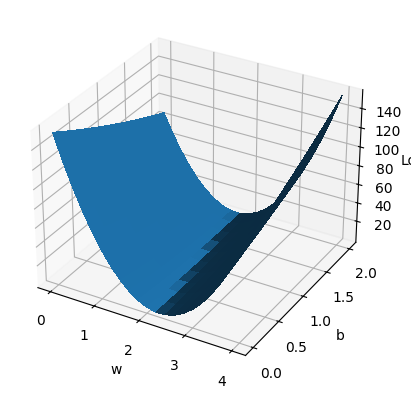

In [6]:
fig = plt.figure()

# enable 3D
ax = fig.add_subplot(projection='3d')

 # generate combinations of weights and biases
(w_list, b_list) = np.meshgrid(weights, biases)

# plot loss across weights and bias values
surf = ax.plot_surface(w_list.T, b_list.T, loss_matrix,
                       linewidth=0, antialiased=False)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('Loss')
plt.show()

### Optimisation with derivatives

Obviously, the brute force search method above is really computationally expensive (very slow!), especially when there are more parameters and more values to search. A more efficient approach is to start from a random set of parameter values, and then try to "move down" the loss graph to the point with a minimum loss. So, in the plot above, you can start at some random $w$ and $b$, and try to move towards the minimum point.

The problem is: from where you are, you actually do not know where the minimum point is. You only know that there *is* a minimum point. The question is: how do you know towards which direction you should move (and how far) so that you can get to the minimum point as fast as possible? The answer is downwards (obviously!) and where the slope is steepest.

Fortunately, calculus saves us from guessing, and provides us a way to compute the direction of the slope at any point. This is called the *derivative* (or gradient). Intuitively, the derivative $\frac{\partial L}{\partial w}$ tells us by how much $L$ changes when $w$ changes. Similarly, $\frac{\partial L}{\partial b}$ tells us by how much $L$ changes when $b$ changes. So if we move in these directions, we hope that we can ultimately reach a minimum point.

If you are well-versed with calculus, you can compute $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ by hand. Otherwise, you can get help from a derivative calculator (e.g. https://www.derivative-calculator.net)

As presented in the lectures, the partial derivatives of the loss function with respect to $w$ and to $b$ are:

$\frac{\partial L}{\partial w} = \sum_{i=1}^{N} \left(\hat{y}^{(i)} - y^{(i)}\right)x^{(i)}$

$\frac{\partial L}{\partial b} = \sum_{i=1}^{N} \left(\hat{y}^{(i)} - y^{(i)}\right)$

Thus, for a *single* point, the partial derivatives are:

$\frac{\partial L^{(i)}}{\partial w} = \left(\hat{y}^{(i)} - y^{(i)}\right)x^{(i)}$

$\frac{\partial L^{(i)}}{\partial b} = \left(\hat{y}^{(i)} - y^{(i)}\right)$

Now, complete the `gradient()` method for `SimpleLinearRegression` below to compute the partial derivatives wrt $w$ and $b$ at a given point. To make life easier, just compute and return both $\frac{\partial L^{(i)}}{\partial w}$ and $\frac{\partial L^{(i)}}{\partial b}$ at the same time.

In [7]:
def gradient(self, x, y):
    """ Compute partial derivatives wrt w and b

    Args:
        x (float): input instance
        y (float): ground truth output

    Returns:
        tuple: (float, float)
            - the first element will be dL/dw
            - the second element will be dL/db
    """
    # TODO: Complete this
    y_hat = self.forward(x)
    return ((y_hat - y)*x, (y_hat - y))


# A quick hack to bind this function as the SimpleLinearRegression.gradient() method
SimpleLinearRegression.gradient = gradient


## Quick test: This should return (6.0, 3.0)
model = SimpleLinearRegression()
model.w = 3
model.b = 2
x = 2.0
y = 5.0
(dLdw, dLdb) = model.gradient(x, y)
print(dLdw) # should print 6.0
print(dLdb) # should print 3.0

6.0
3.0


So, in this example, $\frac{\partial L}{\partial w}=6.0$ suggests that when $w$ increases by a very tiny amount, $L$ will increase by 6.0 times that amount.


#### Gradient descent

Now that we have our gradients, let us try to optimise the parameters $w$ and $b$ of our model to minimise the loss. We will use the gradient descent algorithm for this, as discussed in the lectures.

You may reimplement the code provided in the lectures, replacing some of the code by reusing the `forward()`, `loss()` and `gradient()` methods of `SimpleLinearRegression` that you implemented earlier. This will help make your code more modular and readable, and help to improve your understanding of gradient descent at a more abstract level.

You should be able to obtain $w \approx 2$ and $b \approx 1$ by the end of training if you have implemented everything correctly. Also experiment with the learning rate and the number of epochs and observe the effects.

In [9]:
model = SimpleLinearRegression()

learning_rate = 0.01
n_epochs = 100

for epoch in range(n_epochs):
    error = 0.0
    grad_w = 0.0
    grad_b = 0.0
    for (x, y) in zip(x_train, y_train):
        ### TODO: Complete this
        ### 1. Compute the gradients for w and b for this example
        (dLdw, dLdb) = model.gradient(x, y)

        ### 2. Add the gradients to grad_w and grad_b
        grad_w += dLdw
        grad_b += dLdb

        ### 3. Add the "local" loss to the global error (Loss) for analysis
        error += model.loss(x,y)

    # TODO: Update the weights using the (summed) gradients
    model.w = model.w - learning_rate*grad_w
    model.b = model.b - learning_rate*grad_b

    print(f"Epoch: {epoch}\t w: {model.w:.2f}\t b: {model.b:.2f}\t L: {error:.4f}")


Epoch: 0	 w: 1.48	 b: 0.35	 L: 236.7588
Epoch: 1	 w: 1.90	 b: 0.47	 L: 30.3327
Epoch: 2	 w: 2.04	 b: 0.52	 L: 4.2502
Epoch: 3	 w: 2.09	 b: 0.55	 L: 0.9462
Epoch: 4	 w: 2.11	 b: 0.56	 L: 0.5195
Epoch: 5	 w: 2.12	 b: 0.57	 L: 0.4565
Epoch: 6	 w: 2.12	 b: 0.58	 L: 0.4396
Epoch: 7	 w: 2.12	 b: 0.58	 L: 0.4287
Epoch: 8	 w: 2.11	 b: 0.59	 L: 0.4188
Epoch: 9	 w: 2.11	 b: 0.60	 L: 0.4093
Epoch: 10	 w: 2.11	 b: 0.60	 L: 0.4000
Epoch: 11	 w: 2.11	 b: 0.61	 L: 0.3909
Epoch: 12	 w: 2.11	 b: 0.61	 L: 0.3821
Epoch: 13	 w: 2.11	 b: 0.62	 L: 0.3734
Epoch: 14	 w: 2.10	 b: 0.63	 L: 0.3650
Epoch: 15	 w: 2.10	 b: 0.63	 L: 0.3568
Epoch: 16	 w: 2.10	 b: 0.64	 L: 0.3488
Epoch: 17	 w: 2.10	 b: 0.65	 L: 0.3410
Epoch: 18	 w: 2.10	 b: 0.65	 L: 0.3333
Epoch: 19	 w: 2.09	 b: 0.66	 L: 0.3259
Epoch: 20	 w: 2.09	 b: 0.66	 L: 0.3186
Epoch: 21	 w: 2.09	 b: 0.67	 L: 0.3115
Epoch: 22	 w: 2.09	 b: 0.67	 L: 0.3046
Epoch: 23	 w: 2.09	 b: 0.68	 L: 0.2979
Epoch: 24	 w: 2.09	 b: 0.68	 L: 0.2913
Epoch: 25	 w: 2.09	 b: 0.69	 L: 

### Predictions

Now that your model is trained, you can use it to predict some unknown test instances. Complete the code below to predict the output of the test set.

In [10]:
y_predictions = np.zeros((len(y_test),))
for (i, x) in enumerate(x_test):
    # TODO: Complete this
    y_predictions[i] = model.forward(x)

print(y_predictions)

[ 5.97796475  6.98350928 10.00014287]


### Evaluation

Finally, let us evaluate the linear regression model you developed. Unlike classification, we will need a different metric for regression. Recall from Lecture 3, a common evaluation metric for regression is the Mean Squared Error (MSE). We will use that for this tutorial.

Complete the `mse()` function below to compute the MSE.

In [11]:
def mse(y_gold, y_prediction):
    """ Compute the MSE given the ground truth and predictions

    Args:
        y_gold (np.ndarray): the correct ground truth values of y
        y_prediction (np.ndarray): the predicted values of y

    Returns:
        float : MSE
    """

    assert len(y_gold) == len(y_prediction)

    # TODO: Complete this
    return np.square(y_gold - y_prediction).mean()


# Compute the MSE on model predictions on our toy test data
# You should be able to obtain a very small MSE rate
print(mse(y_test, y_predictions))

0.003576314517982279


## Iris Dataset (Extra exercise)

Here is an extra optional exercise for you: try to get your simple linear regression model working on a (slightly) larger and noisier dataset.

For this, we will convert the Iris dataset to use as a regression task. More specifically, our task is to predict the *petal width* of a flower (`y`) given the *sepal length* as input (`x`). The code below will give you the dataset in this format.

In [12]:
import os

# Download iris data if it does not exist
if not os.path.exists("iris.data"):
    !wget -O iris.data https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

def read_dataset_as_regression(filepath):
    """ Read in the dataset from the specified filepath

    Args:
        filepath (str): The filepath to the dataset file

    Returns:
        tuple: returns a tuple of (x, y), each being a numpy array.
               - x is a numpy array with shape (N, ),
                   where N is the number of instances
               - y is a numpy array with shape (N, ), where each element is a
                real-valued float, and N is the number of instances
    """

    x = []
    y = []
    for line in open(filepath):
        if line.strip() != "": # handle empty rows in file
            row = line.strip().split(",")
            # extract columns 0 as x.
            x.append(float(row[0]))

            # extract column 3 as y
            y.append(float(row[3]))

    return (np.array(x), np.array(y))


def split_dataset(x, y, test_proportion, random_generator=default_rng()):
    """ Split dataset into training and test sets, according to the given
        test set proportion.

    Args:
        x (np.ndarray): Instances, numpy array with shape (N,K)
        y (np.ndarray): Output label, numpy array with shape (N,)
        test_proprotion (float): the desired proportion of test examples
                                 (0.0-1.0)
        random_generator (np.random.Generator): A random generator

    Returns:
        tuple: returns a tuple of (x_train, x_test, y_train, y_test)
               - x_train (np.ndarray): Training instances shape (N_train, K)
               - x_test (np.ndarray): Test instances shape (N_test, K)
               - y_train (np.ndarray): Training labels, shape (N_train, )
               - y_test (np.ndarray): Test labels, shape (N_test, )
    """

    shuffled_indices = random_generator.permutation(len(x))
    n_test = round(len(x) * test_proportion)
    n_train = len(x) - n_test
    x_train = x[shuffled_indices[:n_train]]
    y_train = y[shuffled_indices[:n_train]]
    x_test = x[shuffled_indices[n_train:]]
    y_test = y[shuffled_indices[n_train:]]
    return (x_train, x_test, y_train, y_test)


(x, y) = read_dataset_as_regression("iris.data")
print(x.shape)  # (150,)
print(y.shape)  # (150,)

seed = 60012
rg = default_rng(seed)
x_train, x_test, y_train, y_test = split_dataset(x, y,
                                                 test_proportion=0.2,
                                                 random_generator=rg)
print(x_train.shape)
print(x_test.shape)


--2024-11-20 14:25:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.data’

iris.data               [ <=>                ]   4.44K  --.-KB/s    in 0s      

2024-11-20 14:25:50 (59.4 MB/s) - ‘iris.data’ saved [4551]

(150,)
(150,)
(120,)
(30,)


As usual, it's always a good idea to examine your data before you start:

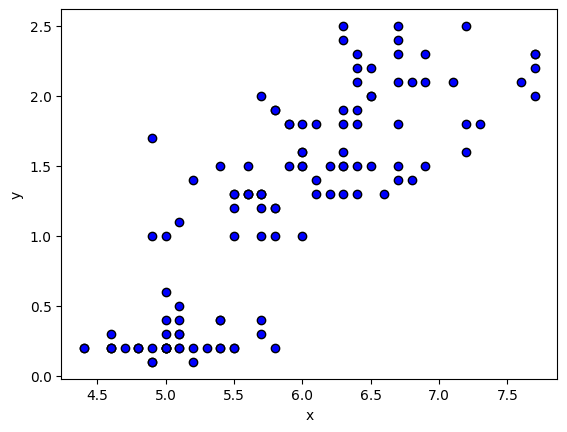

In [15]:
plt.figure()
plt.scatter(x_train, y_train, c="blue", edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Model

You can copy your `SimpleLinearRegression` class from earlier, with the`forward()`, `loss()` and `gradient()` methods that you implemented earlier. This time you can put them all together in the same place.

In [29]:
class SimpleLinearRegression:
    def __init__(self, random_generator=default_rng()):
        self.w = random_generator.standard_normal()
        self.b = 0

    def forward(self, x):
        return self.w * x + self.b

    def loss(self, x, y):
        y_hat = self.forward(x)
        return (y_hat - y)**2

    def gradient(self, x, y):
        y_hat = self.forward(x)
        return ((y_hat - y) * x, (y_hat - y))

### Optimisation

Again, you should not need to change much of your gradient descent implementation from earlier, so just copy it over. You may, however, need to tweak the learning rate and the number of epochs to obtain a reasonable output.

In [34]:
model = SimpleLinearRegression()

learning_rate = 0.0001
n_epochs = 100

for epoch in range(n_epochs):
    error = 0.0
    grad_w = 0.0
    grad_b = 0.0
    for (x, y) in zip(x_train, y_train):
        ### TODO: Complete this
        ### 1. Compute the gradients for w and b for this example
        (dLdw, dLdb) = model.gradient(x, y)

        ### 2. Add the gradients to grad_w and grad_b
        grad_w += dLdw
        grad_b += dLdb

        ### 3. Add the "local" loss to the global error (Loss) for analysis
        error += model.loss(x, y)

    # TODO: Update the weights using the (summed) gradients
    model.w = model.w - learning_rate * grad_w
    model.b = model.b - learning_rate * grad_b

    print(f"Epoch: {epoch}\t w: {model.w:.2f}\t b: {model.b:.2f}\t L: {error:.4f}")


Epoch: 0	 w: -0.34	 b: 0.07	 L: 3960.3818
Epoch: 1	 w: -0.11	 b: 0.11	 L: 1313.9272
Epoch: 2	 w: 0.02	 b: 0.13	 L: 457.9120
Epoch: 3	 w: 0.09	 b: 0.14	 L: 181.0225
Epoch: 4	 w: 0.13	 b: 0.14	 L: 91.4537
Epoch: 5	 w: 0.16	 b: 0.15	 L: 62.4748
Epoch: 6	 w: 0.17	 b: 0.15	 L: 53.0939
Epoch: 7	 w: 0.18	 b: 0.15	 L: 50.0520
Epoch: 8	 w: 0.19	 b: 0.15	 L: 49.0606
Epoch: 9	 w: 0.19	 b: 0.15	 L: 48.7324
Epoch: 10	 w: 0.19	 b: 0.15	 L: 48.6187
Epoch: 11	 w: 0.19	 b: 0.15	 L: 48.5744
Epoch: 12	 w: 0.19	 b: 0.15	 L: 48.5526
Epoch: 13	 w: 0.19	 b: 0.15	 L: 48.5380
Epoch: 14	 w: 0.19	 b: 0.15	 L: 48.5257
Epoch: 15	 w: 0.19	 b: 0.15	 L: 48.5143
Epoch: 16	 w: 0.19	 b: 0.14	 L: 48.5030
Epoch: 17	 w: 0.19	 b: 0.14	 L: 48.4919
Epoch: 18	 w: 0.19	 b: 0.14	 L: 48.4808
Epoch: 19	 w: 0.19	 b: 0.14	 L: 48.4697
Epoch: 20	 w: 0.19	 b: 0.14	 L: 48.4586
Epoch: 21	 w: 0.19	 b: 0.14	 L: 48.4475
Epoch: 22	 w: 0.19	 b: 0.14	 L: 48.4365
Epoch: 23	 w: 0.19	 b: 0.14	 L: 48.4254
Epoch: 24	 w: 0.19	 b: 0.14	 L: 48.4143
Ep

### Visualising your trained model

You can visualise your model by plotting the line on the graph.

We will also plot the test instances to get a rough idea of how well we expect it to perform.

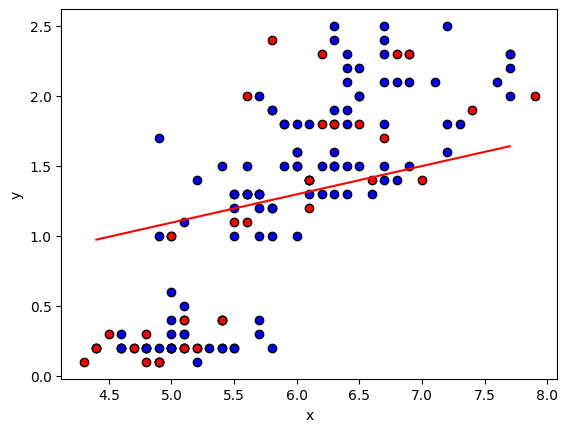

In [36]:
# Plot training instances
plt.figure()
plt.scatter(x_train, y_train, c="blue", edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")

# Draw the line representing the model
xmin = x_train.min()
ymin = model.forward(xmin)
xmax = x_train.max()
ymax = model.forward(xmax)
plt.plot([xmin, xmax], [ymin, ymax], 'r-')

# Plot test instances
plt.scatter(x_test, y_test, c="red", edgecolor='k')

plt.show()


### Predictions and evaluation

Finally, predict the test instances given the model.

Then evaluate the model with MSE.


In [37]:
y_predictions = np.zeros((len(y_test),))
for (i, x) in enumerate(x_test):
    y_predictions[i] = model.forward(x)

print(y_predictions)
print(y_test)

print(mse(y_test, y_predictions))

[1.41836104 1.35773277 1.2162668  1.68108356 1.11521968 1.19605737
 1.58003644 1.11521968 1.0545914  1.39815162 1.45877989 1.25668565
 1.33752335 1.1354291  1.33752335 1.07480083 0.97375371 1.47898932
 1.31731392 1.43857047 1.2162668  1.31731392 1.31731392 1.09501025
 1.49919874 0.95354428 1.0545914  1.17584795 1.03438198 0.99396313]
[1.4 1.8 1.1 2.  0.2 1.1 1.9 0.4 0.1 1.8 2.3 2.4 1.8 0.2 2.3 0.1 0.2 2.3
 1.4 1.7 2.  1.2 1.4 1.  1.4 0.1 0.3 0.4 0.2 0.3]
0.4301431203882206


## Summary

Hopefully you have managed to deepen your understanding about linear regression by implementing the model, loss function, and the gradient descent algorithm, and putting everything together for training and testing.

In the next lab exercise, we will delve a bit deeper at implementation level, and try to extend your model to handle more than one input variable. We will also start making your code a bit more efficient with vectorised implementations so that you can perform computations on multiple training instances simultaneously. This will hopefully help you get started on implementing Neural Networks (which we will unfortunately not cover in these lab exercises as it is part of your second coursework).  

